# Pitch recognition from speech
Use already extracted features (matrix) of audio signals
<br> Train baseline LogReg model
<br> Train SVM model


In [1]:
import matplotlib.pyplot as plt
import rarfile
import subprocess
import random
import re

from IPython.display import Audio
import librosa
import librosa.display
import librosa.feature as lf
import soundfile as sf
import speech_recognition as sr

import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
%%time
# extract rar
rar_path = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations.rar"
out_dir = r"C:\Users\USER\Documents\..."

subprocess.run([r"C:\Users\USER\Documents\...\UnRAR.exe", "x", "-y", rar_path, out_dir])


## Loading and Visualizing an Audio File

In [4]:
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations"

In [5]:
# processed audio signals
datatype = "Wave"
target = "Exclamations"
person = "1"
wav_path = os.path.join(dataset_dir, datatype , target, person, "1EF001.wav")
audio_signal, sample_rate = librosa.load(wav_path, sr=None)

In [6]:
sample_rate 

16000

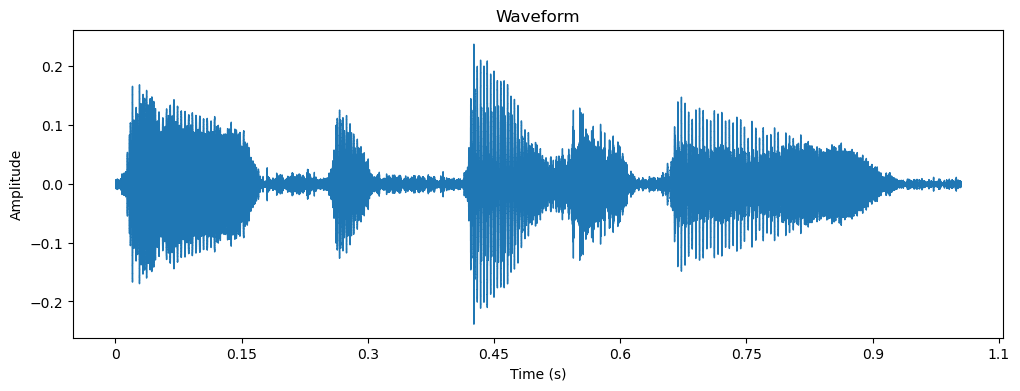

In [7]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_signal, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [8]:
# Play the audio in the notebook
Audio(wav_path)

## Read features file

In [9]:
# QC
# 12660
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Matrix"
all_files = list(Path(dataset_dir).rglob("*.Matrix"))
print(len(all_files))  # raw count
# print(sorted(all_files)[:10])  # first 10 paths

12660


In [10]:
def parse_matrix_file(fpath):
    """
    Parse Praat .Matrix file into numpy array (ny x nx)
    """
    coeffs = []
    current_row = []
    prev_row = 1

    with open(fpath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("z [") and "=" in line:
                # line example: z [1] [1] = -117.91916255392843
                parts = line.split("=")
                val = float(parts[1].strip())
                
                # extract row and col index from left side
                indices = parts[0].replace("z", "").replace("[", "").replace("]", "").split()
                row_idx, col_idx = int(indices[0]), int(indices[1])
                
                if row_idx != prev_row:
                    coeffs.append(current_row)
                    current_row = []
                    prev_row = row_idx
                
                current_row.append(val)

    # append the last row
    if current_row:
        coeffs.append(current_row)
    return np.array(coeffs)


In [11]:
def extract_features_from_matrix(matrix):
    '''
    Extract features from MFCC matrix
    '''
    features = {}
    for i, coeff in enumerate(matrix):  # each row = MFCC track
        cid = f"mfcc{i+1}"
        features[f"{cid}_mean"] = np.mean(coeff)
        features[f"{cid}_std"] = np.std(coeff)
        features[f"{cid}_min"] = np.min(coeff)
        features[f"{cid}_max"] = np.max(coeff)
        features[f"{cid}_median"] = np.median(coeff)
        features[f"{cid}_range"] = np.max(coeff) - np.min(coeff)
        features[f"{cid}_skew"] = skew(coeff)
        features[f"{cid}_kurtosis"] = kurtosis(coeff)
        
        # temporal dynamics
        diff = np.diff(coeff)
        features[f"{cid}_delta_mean"] = np.mean(diff)
        features[f"{cid}_delta_std"] = np.std(diff)
    return features


In [12]:
def build_dataset_matrix(dataset_dir, targets=["Statements", "Questions", "Exclamations"]):
    '''
    Build df from extracted features
    '''
    rows = []
    for target in targets:
        target_dir = os.path.join(dataset_dir, target)
        if not os.path.isdir(target_dir):
            continue
        
        for root, _, files in os.walk(target_dir):
            print(f"\nScanning directory: {root}")  
            for fname in tqdm(files, desc=f"Processing {target}"):
                if not fname.endswith(".Matrix"):
                    continue
                fpath = os.path.join(root, fname)
                try:
                    matrix = parse_matrix_file(fpath)
                    feats = extract_features_from_matrix(matrix)
                    feats["label"] = target.lower()
                    feats["file"] = fname
                    rows.append(feats)
                except Exception as e:
                    print(f"Skipping {fname}: {e}")
    return pd.DataFrame(rows)


In [13]:
# %%time
# dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Matrix"
# df = build_dataset_matrix(dataset_dir)


In [14]:
# df.head()

In [15]:
# df.shape

In [16]:
# df.to_csv("features_from_matrix.csv", index=False)
# print("Saved features to features_from_matrix.csv")


**load df if already saved**

In [17]:
df = pd.read_csv("features_from_matrix.csv")

print(f"Number of rows: {len(df)}, number of columns: {len(df.columns)}")
print(f"Labels: {df['label'].unique()}")

Number of rows: 12660, number of columns: 122
Labels: ['statements' 'questions' 'exclamations']


In [18]:
df.shape

(12660, 122)

In [19]:
df.head()

,mfcc1_mean,mfcc1_std,mfcc1_min,mfcc1_max,mfcc1_median,mfcc1_range,mfcc1_skew,mfcc1_kurtosis,mfcc1_delta_mean,mfcc1_delta_std,...,mfcc12_min,mfcc12_max,mfcc12_median,mfcc12_range,mfcc12_skew,mfcc12_kurtosis,mfcc12_delta_mean,mfcc12_delta_std,label,file
0,121.317710,140.183987,-169.403097,312.472392,162.228364,481.875490,-0.550869,-1.051849,1.326016,24.896630,...,-31.086112,24.696118,-5.790495,55.782229,0.099577,-0.362616,0.082193,10.343504,statements,1SF001.Matrix
1,95.974960,124.743097,-169.216888,294.270266,132.021469,463.487155,-0.762345,-0.580531,1.020672,25.795255,...,-49.109207,29.394252,-8.428696,78.503459,0.010551,0.057849,0.073553,11.013481,statements,1SF002.Matrix
2,157.995999,107.720851,-105.531575,324.406992,188.533120,429.938566,-0.867955,-0.206220,1.560224,24.319041,...,-40.088773,31.173667,-3.711243,71.262440,0.081220,-0.050632,-0.080003,10.750993,statements,1SF003.Matrix
3,154.168562,102.184337,-106.554125,337.437145,168.503876,443.991270,-0.475035,-0.356041,1.279203,26.307345,...,-35.091894,42.900711,-1.140463,77.992605,0.159392,0.070239,-0.042364,11.213742,statements,1SF004.Matrix
4,176.574278,120.041180,-115.492658,328.077894,217.193673,443.570552,-1.041020,-0.067197,1.707303,25.313882,...,-49.922503,21.543831,-4.618977,71.466334,-0.665358,0.156655,0.022889,10.859231,statements,1SF005.Matrix


In [22]:
drop_cols = ['file']
df.drop(columns=drop_cols, inplace=True)

## Model training

### Logistic Regression (baseline)

In [23]:
# === Train + evaluation ===
def train_and_eval_logreg(df: pd.DataFrame):
    '''
    Train Logistic Regression model as baseline
    '''
    print(f"Train and evaluate Logistic Regression (baseline) model")
    df = df.copy()
    
    # Prepare features & labels
    meta_cols = ["label", "path"]
    X = df.drop(columns=meta_cols, errors="ignore")
    X = X.loc[:, X.notna().any(axis=0)]
    X = X.fillna(X.median(numeric_only=True))
    y = df["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    pipeline = Pipeline([
        ('var_thresh', VarianceThreshold(threshold=0.0001)),  # drop near-constant features
        ('logreg', LogisticRegression(
            C=1.0, 
            solver='saga', 
            penalty='l2', 
            max_iter=500,
            n_jobs=-1,
            random_state=random_state
        ))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"CV accuracy (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # y_proba = pipeline.predict_proba(X_test)

    print(f"Holdout accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Get selected features
    support_mask = pipeline.named_steps["var_thresh"].get_support()
    selected_features = np.array(X.columns)[support_mask]
    print(f"Trained on {len(selected_features)} feature columns (after variance threshold).")

    return pipeline, selected_features.tolist()


In [24]:
%%time
random_state = 42
model, selected_features = train_and_eval_logreg(df)  


Train and evaluate Logistic Regression (baseline) model


C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CV accuracy (mean ± std): 0.510 ± 0.009
Holdout accuracy: 0.513
Classification report:
               precision    recall  f1-score   support

exclamations       0.47      0.44      0.46       840
   questions       0.52      0.51      0.51       845
  statements       0.54      0.59      0.56       847

    accuracy                           0.51      2532
   macro avg       0.51      0.51      0.51      2532
weighted avg       0.51      0.51      0.51      2532

Confusion matrix:
 [[372 241 227]
 [224 429 192]
 [195 155 497]]
Trained on 120 feature columns (after variance threshold).
CPU times: total: 1min 22s
Wall time: 1min 34s


C:\Users\USER\anaconda3\envs\speech_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### SVM

In [25]:
# === Train + evaluation ===
def train_and_eval_svm(df: pd.DataFrame):
    '''
    Train SVM model
    '''
    print(f"Train and evaluate SVM model")
    df = df.copy()
    meta_cols = ["label", "path"]
    X = df.drop(columns=meta_cols, errors="ignore")
    X = X.loc[:, X.notna().any(axis=0)]
    X = X.fillna(X.median(numeric_only=True))
    y = df["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Add VarianceThreshold before scaling
    pipe = Pipeline([
        ("var", VarianceThreshold(threshold=0.0001)),  # remove low variance features
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=5, gamma="scale", 
                    probability=False, random_state=random_state))
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"CV accuracy (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Fit and evaluate on holdout
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"Holdout accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Get selected features
    support_mask = pipe.named_steps["var"].get_support()
    selected_features = np.array(X.columns)[support_mask]
    print(f"Trained on {len(selected_features)} feature columns (after variance threshold).")

    return pipe, selected_features.tolist()


In [26]:
 # SVM with VarianceThreshold
model, selected_features = train_and_eval_svm(df) 


Train and evaluate SVM model
CV accuracy (mean ± std): 0.583 ± 0.011
Holdout accuracy: 0.613
Classification report:
               precision    recall  f1-score   support

exclamations       0.58      0.60      0.59       840
   questions       0.62      0.61      0.62       845
  statements       0.63      0.62      0.63       847

    accuracy                           0.61      2532
   macro avg       0.61      0.61      0.61      2532
weighted avg       0.61      0.61      0.61      2532

Confusion matrix:
 [[506 163 171]
 [190 518 137]
 [172 148 527]]
Trained on 120 feature columns (after variance threshold).
